In [1]:
import os
import keras
import tensorflow as tf
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    zoom_range=0.3,
    horizontal_flip=True, 
    validation_split=0.01)

test_generator = ImageDataGenerator() 

In [3]:
download_dir = Path("./oct2017/OCT2017 /")

In [4]:
train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'

class_subset = ['CNV', 'DME', 'DRUSEN', 'NORMAL'] 

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=IMG_SIZE,
                                               class_mode='categorical',
                                               subset='training',
                                               classes=class_subset,
                                               batch_size=BATCH_SIZE,
                                               interpolation='bilinear', 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=IMG_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset = 'validation',
                                               batch_size=BATCH_SIZE,
                                               interpolation='bilinear',
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='categorical',
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 82650 images belonging to 4 classes.
Found 834 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [5]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image #.numpy()
    label = label #.numpy()

    fig = plt.figure(figsize=(22, 22))
    for i in range(16):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i].astype(np.int32))
        ax.set_title(f"Label: {label[i]}")

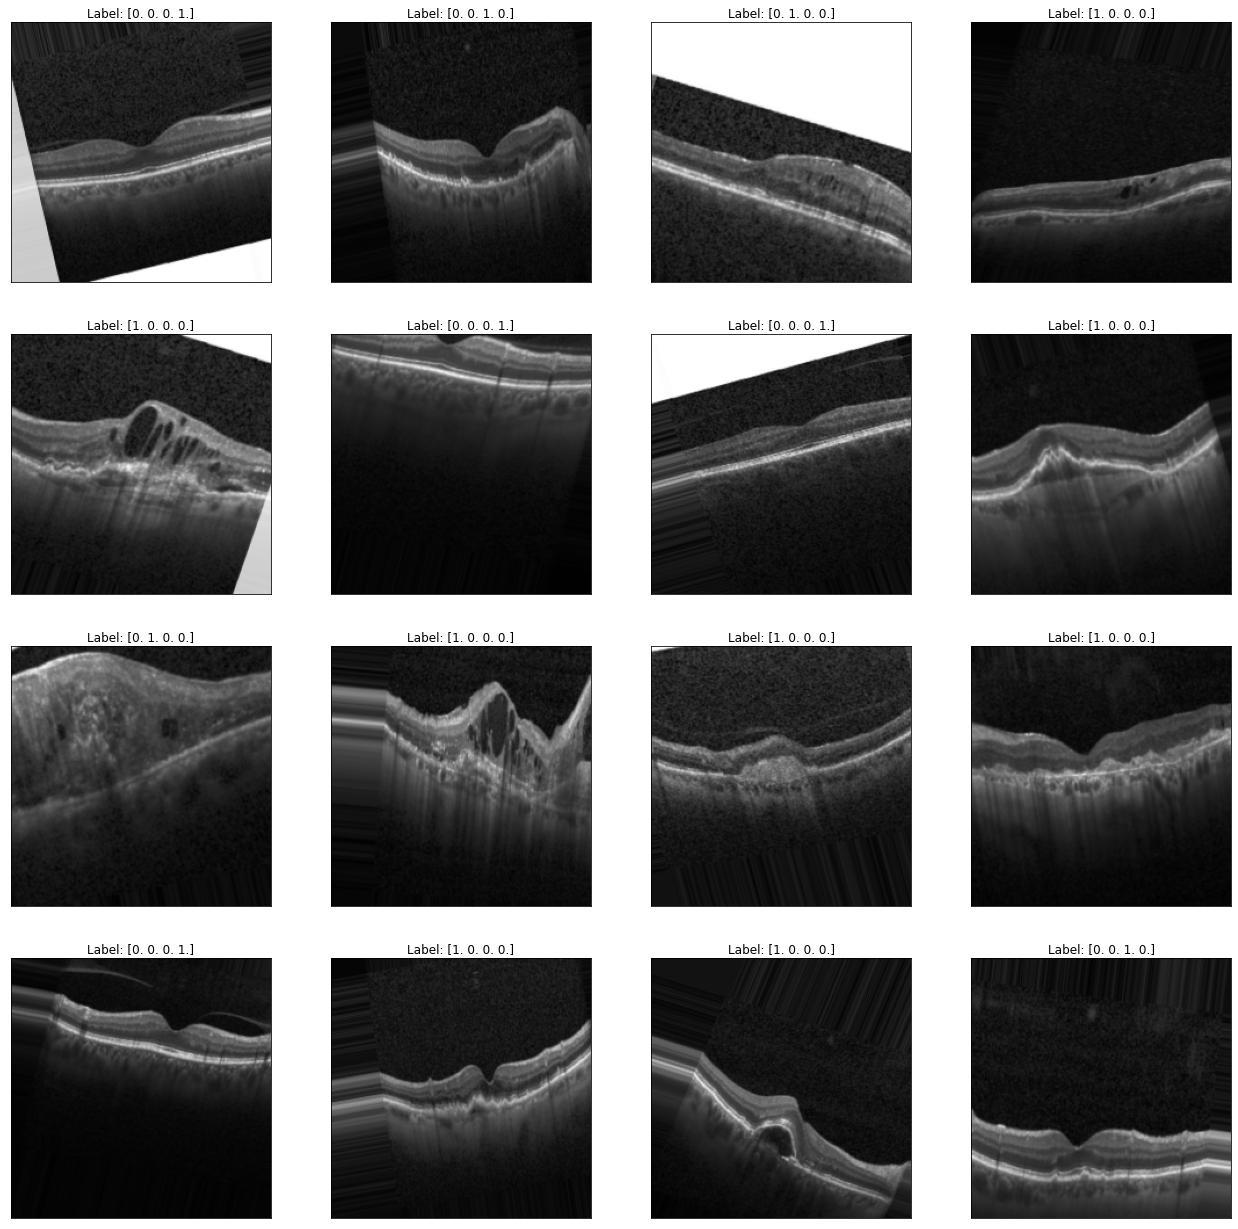

In [6]:
view_image(traingen)

In [7]:
def create_basemodel(base_model='resnet', 
                     input_shape=(224,224,3),
                     output_units=4):
  

  preprocess = tf.keras.applications.resnet_v2.preprocess_input
  base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
  base_model.trainable = False

  inputs = tf.keras.layers.Input(input_shape)
  pool    = tf.keras.layers.GlobalAveragePooling2D()
  flatten = tf.keras.layers.Flatten()

  softmax   = tf.keras.layers.Dense(output_units, activation='softmax')

  x = inputs
  x = preprocess(x)
  x = base_model(x)
  x = pool(x)
  x = flatten(x)
  out = softmax(x)

  return tf.keras.Model(inputs=inputs, outputs=out)

In [8]:
resnet_base = create_basemodel('resnet')

metrics = ['accuracy']
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', ),
             tf.keras.callbacks.ModelCheckpoint(filepath='resnet_model.{epoch:02d}-{val_loss:.2f}.h5'),]
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
resnet_base.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=metrics)

2022-06-22 16:30:13.615305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 16:30:13.754750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 16:30:13.755384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 16:30:13.756602: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

94683136/94668760 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
resnet_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [10]:
resnet_history = resnet_base.fit(traingen,
                                   validation_data=validgen,
                                   callbacks=callbacks,
                                   epochs=10)

Epoch 1/10


2022-06-22 16:35:09.035942: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


5166/5166 [==============================] - 2430s 468ms/step - loss: 0.5346 - accuracy: 0.8063 - val_loss: 0.6457 - val_accuracy: 0.8106
Epoch 2/10
5166/5166 [==============================] - 1163s 225ms/step - loss: 0.4740 - accuracy: 0.8315 - val_loss: 0.6232 - val_accuracy: 0.7602
Epoch 3/10
5166/5166 [==============================] - 1161s 225ms/step - loss: 0.4667 - accuracy: 0.8350 - val_loss: 0.4838 - val_accuracy: 0.8321
Epoch 4/10
5166/5166 [==============================] - 1165s 226ms/step - loss: 0.4588 - accuracy: 0.8362 - val_loss: 0.4914 - val_accuracy: 0.8285
Epoch 5/10
5166/5166 [==============================] - 1169s 226ms/step - loss: 0.4582 - accuracy: 0.8364 - val_loss: 0.5098 - val_accuracy: 0.8058
Epoch 6/10
5166/5166 [==============================] - 1170s 226ms/step - loss: 0.4535 - accuracy: 0.8403 - val_loss: 0.5304 - val_accuracy: 0.8058


In [11]:
resnet_base.evaluate(testgen)

968/968 [==============================] - 12s 12ms/step - loss: 0.2307 - accuracy: 0.9194


[0.23074863851070404, 0.9194214940071106]

In [12]:
resnet_base.save("Models/resnet_initial")

2022-06-22 18:58:43.731007: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Models/resnet_initial/assets


## Fine tuning layers

In [13]:
# Extract the base model
base_model = resnet_base.layers[3]

# unfreeze it
base_model.trainable = True

# select only the last resnet block for retraining
# keeping the batchnorm layer unchanged
for l in base_model.layers:
  name = l.name
  if name.startswith('conv5_block3') and not isinstance(l, tf.keras.layers.BatchNormalization):
    l.trainable = True
  else:
    l.trainable = False

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
resnet_base.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=metrics)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
resnet_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [15]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', ),
             tf.keras.callbacks.ModelCheckpoint(filepath='finetune_resnet_model.{epoch:02d}-{val_loss:.2f}.h5'),]

finetune_history = resnet_base.fit(traingen,
                                   validation_data=validgen,
                                   callbacks=callbacks,
                                   epochs=10)

Epoch 1/10
5166/5166 [==============================] - 1173s 226ms/step - loss: 0.3279 - accuracy: 0.8848 - val_loss: 0.3644 - val_accuracy: 0.8669
Epoch 2/10
5166/5166 [==============================] - 1171s 227ms/step - loss: 0.2599 - accuracy: 0.9089 - val_loss: 0.3001 - val_accuracy: 0.8789
Epoch 3/10
5166/5166 [==============================] - 1172s 227ms/step - loss: 0.2403 - accuracy: 0.9162 - val_loss: 0.2700 - val_accuracy: 0.9065
Epoch 4/10
5166/5166 [==============================] - 1171s 227ms/step - loss: 0.2262 - accuracy: 0.9216 - val_loss: 0.3120 - val_accuracy: 0.8873
Epoch 5/10
5166/5166 [==============================] - 1162s 225ms/step - loss: 0.2178 - accuracy: 0.9246 - val_loss: 0.3068 - val_accuracy: 0.9005
Epoch 6/10
5166/5166 [==============================] - 1171s 227ms/step - loss: 0.2080 - accuracy: 0.9275 - val_loss: 0.2829 - val_accuracy: 0.8993


In [16]:
resnet_base.evaluate(testgen)

968/968 [==============================] - 11s 12ms/step - loss: 0.0510 - accuracy: 0.9866


[0.05102879926562309, 0.9865702390670776]

In [17]:
resnet_base.save("Models/resnet_initial_ft")

INFO:tensorflow:Assets written to: Models/resnet_initial_ft/assets
